# AutoDEUQ: Automated Deep Ensemble with Uncertainty Quantification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/3-Ensemble-and-Uncertainty-Quantification.ipynb)

In this tutorial we will present leverage the outcomes from neural architecture to build ensemble and performe uncertainty quantification for timeseries on the sea-surface temperature prediction problem.

In [1]:
IN_COLAB = False
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

False


In [2]:
#Install dependencies if running in google collab
if IN_COLAB:
    !rm -rf deephyper_repo/
    !git clone -b develop https://github.com/deephyper/deephyper.git deephyper_repo
    !pip install -e "deephyper_repo/[nas,popt,autodeuq]" --use-feature=in-tree-build
    !pip install matplotlib==3.5.2 progressbar
    !git clone https://github.com/deephyper/anl-22-summer-workshop.git

In [3]:
# Download the data if running in google collab
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/notebooks/data
    !gdown 1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
    !gdown 1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
    !gdown 1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU

In [4]:
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/notebooks/
    
import gzip

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

from data.utils import load_sst_data, load_data_prepared

from deephyper.nas.metrics import r2, mse

In [5]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## The data

Let's start by loading the raw training data with shape `(timestep, latitude, longitude)` containing temperature with Celsius as unit

In [6]:
train_data, test_data, mask = load_sst_data()
train_data.shape

(427, 180, 360)

Then we can visualize a specific timestep (the first week), let's try with the first one.

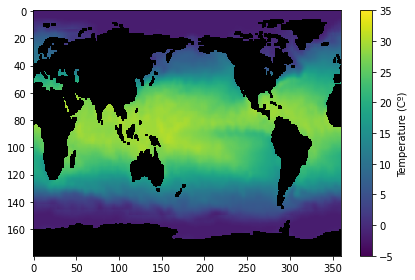

In [7]:
palette = plt.cm.viridis.with_extremes(over='r', under='r', bad='black')

def plot_raw_data(idx):
    snapshot = train_data[idx].copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked = np.ma.masked_where(snapshot == 100, snapshot)


    plt.figure()
    im = plt.imshow(snapshot_masked, cmap=palette, vmin=-5,vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()
    plt.show()

plot_raw_data(idx=0)

## Baseline LSTM Model

In [8]:
def nll(y, rv_y):
    """Negative log likelihood for Tensorflow probability.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)

In [9]:
def build_and_train_model(config: dict, n_components: int = 5, verbose: bool = 0):
    tf.keras.utils.set_random_seed(42)

    default_config = {
        "lstm_units": 128,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "dropout_rate": 0,
        "num_layers": 1,
        "epochs": 20,
    }
    default_config.update(config)

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared(
        n_components=n_components
    )

    layers = []
    for _ in range(default_config["num_layers"]):
        lstm_layer = tf.keras.layers.LSTM(
            default_config["lstm_units"],
            activation=default_config["activation"],
            recurrent_activation=default_config["recurrent_activation"],
            return_sequences=True,
        )
        dropout_layer = tf.keras.layers.Dropout(default_config["dropout_rate"])
        layers.extend([lstm_layer, dropout_layer])

    model = tf.keras.Sequential(
        [tf.keras.Input(shape=X_train.shape[1:])]
        + layers
        + [
            tf.keras.layers.Dense(n_components * 2),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :n_components],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., n_components:]),
                )
            ),
        ]
    )

    if verbose:
        model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, loss=nll, metrics=[])

    history = model.fit(
        X_train,
        y_train,
        epochs=default_config["epochs"],
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose,
    ).history

    return model, history

In [10]:
n_components = 5

model, history = build_and_train_model(config={}, n_components=n_components, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense (Dense)               (None, 8, 10)             1290      
                                                                 
 distribution_lambda (Distri  ((None, 8, 5),           0         
 butionLambda)                (None, 8, 5))                      
                                                                 
Total params: 69,898
Trainable params: 69,898
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2022-07-11 15:56:02.961852: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-11 15:56:02.989573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 1s 30ms/step - loss: 0.7127 - val_loss: 0.6521
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 0.6329 - val_loss: 0.6158
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6024 - val_loss: 0.5873
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 0.5773 - val_loss: 0.5630
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 0.5456 - val_loss: 0.5166
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 0.4781 - val_loss: 0.4240
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 0.3702 - val_loss: 0.3035
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 0.2508 - val_loss: 0.1968
Epoch 9/20
14/14 [==============================] - 0s 7ms/step - loss: 0.1354 - val_loss: 0.0808
Epoch 10/20
14/14 [==============================] - 0s 7ms/step - loss: 0.0255 - val_loss: -0.0395
Epoch 11/20
14/14 [=========

Let us check the learning performance of this baseline

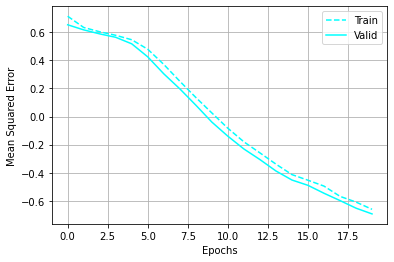

In [11]:
plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.show()

In [12]:
cached_data = f"processed_data_{n_components}_8_8.npz"
with gzip.GzipFile(cached_data, "rb") as f:
    data = np.load(f, allow_pickle=True).item()
    X_train, y_train = data["train"]
    X_valid, y_valid = data["valid"]
    X_test, y_test = data["test"]
    preprocessor = data["preprocessor"]

In [13]:
def inverse_transform(y):
    shape = y.shape
    y = y.reshape(-1, shape[-1])
    y = preprocessor.inverse_transform(y).reshape((*shape[:2], -1))
    return y

We can also visualize a prediction

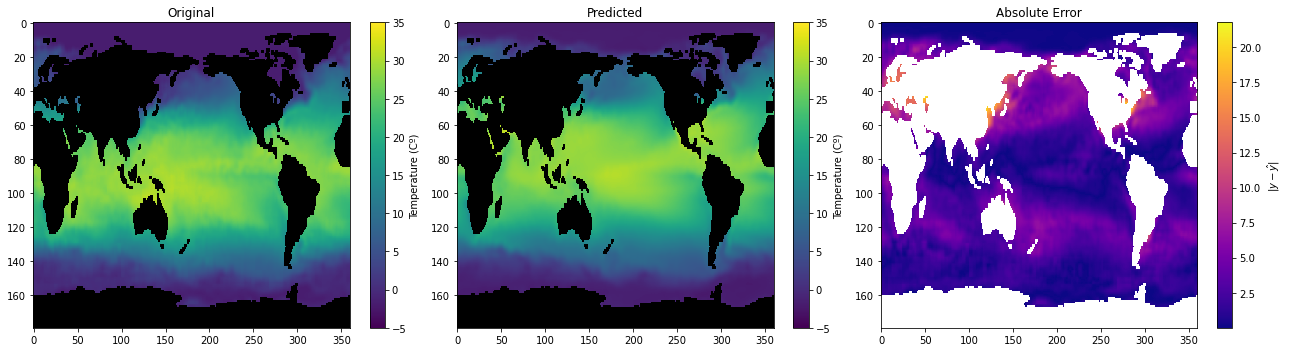

In [14]:
def plot_pred_from_baseline(idx):
    snapshot = train_data[idx].copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

    y_pred = model.predict(X_train)
    y_pred = inverse_transform(y_pred)

    input_horizon = X_train.shape[1]
    inv_y_pred = y_pred[idx-input_horizon][0].reshape(train_data.shape[1:])
    snapshot = inv_y_pred.copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

    plt.figure(figsize=(18, 5))
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Original")
    im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(1, 3, 2)
    ax.set_title("Predicted")

    im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(1, 3, 3)
    ax.set_title("Absolute Error")
    err = np.abs(snapshot_masked_full - snapshot_masked_redu)
    im = plt.imshow(err, cmap="plasma", aspect="auto")
    plt.colorbar(im, label="$|y - \hat{y}|$")
    plt.tight_layout()

    plt.show()

# "idx" should be > than input_horizon!
plot_pred_from_baseline(idx=9)

In [15]:
def print_scores(model):
    scores = {"MSE": mse, "R2": r2}
    model_predict = lambda x: model.predict(x)

    for metric_name, metric_func in scores.items():
        print(f"Metric {metric_name}")

        y_pred = model_predict(X_train)
        score_train = np.mean(metric_func(y_train, y_pred).numpy())

        y_pred = model_predict(X_valid)
        score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

        y_pred = model_predict(X_test)
        score_test = np.mean(metric_func(y_test, y_pred).numpy())

        print(f"train: {score_train:.4f}")
        print(f"valid: {score_valid:.4f}")
        print(f"test : {score_test:.4f}")
        print()

print_scores(model)

Metric MSE
train: 0.0764
valid: 0.0739
test : 0.0781

Metric R2
train: -0.5106
valid: -0.4672
test : -0.9976



## Neural Architecture Search

Wrapping the data in a `load_data` function

In [16]:
def load_data():

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared()

    return (X_train, y_train), (X_valid, y_valid)

Definition the neural architecture search space

In [17]:
import collections

from deephyper.nas import KSearchSpace 
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Identity, Connect, AddByProjecting


Dense = operation(tf.keras.layers.Dense)
LSTM = operation(tf.keras.layers.LSTM)
DistributionLambda = operation(tfp.layers.DistributionLambda)

class VStackedLSTMSpace(KSearchSpace):
    def __init__(self, input_shape, output_shape, seed=None, num_layers=5):
        super().__init__(input_shape, output_shape, seed=seed)

        self.num_layers = num_layers
        self.output_dim = output_shape[-1]

    def build(self):
        source = prev_input = self.input_nodes[0]

        # look over skip connections within a range of the 2 previous nodes
        anchor_points = collections.deque([source], maxlen=2)

        for _ in range(self.num_layers):
            vnode = VariableNode()
            self.add_lstm_seq_(vnode)

            self.connect(prev_input, vnode)

            # * Cell output
            cell_output = vnode

            cmerge = ConstantNode()
            cmerge.set_op(AddByProjecting(self, [cell_output], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, cmerge)

            #! for next iter
            prev_input = cmerge
            anchor_points.append(prev_input)

        cnode = ConstantNode(op=Dense(self.output_dim * 2))  # means and stddev
        self.connect(prev_input, cnode)

        out_node = ConstantNode(
            op=DistributionLambda(
                lambda t: tfd.Normal(
                    loc=t[..., :self.output_dim],
                    scale=1e-3 + tf.math.softplus(0.05 * t[..., self.output_dim:]),
                )
            )
        )
        self.connect(cnode, out_node)

        return self

    def add_lstm_seq_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 129, 16):
            node.add_op(LSTM(units=units, return_sequences=True))

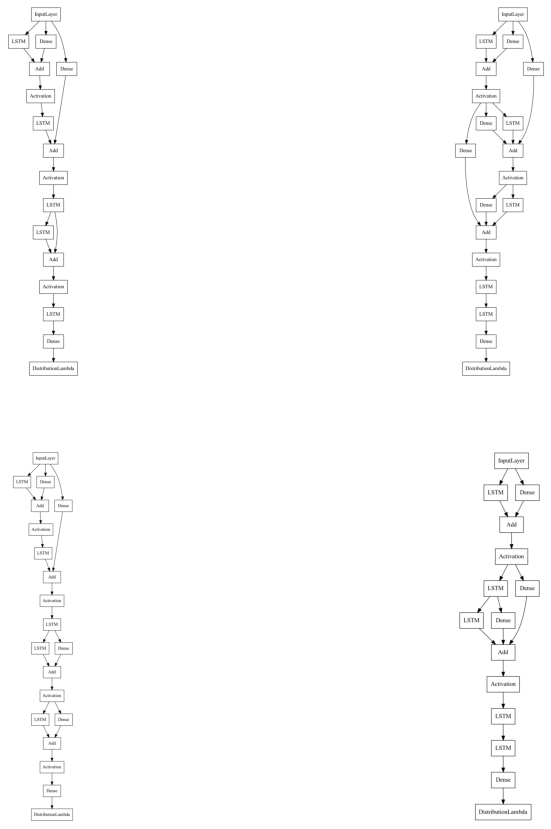

In [18]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(8,5), output_shape=(8,5))
space = VStackedLSTMSpace(**shapes).build()

images = []
plt.figure(figsize=(15,15))
for i in range(4):

    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [19]:
from deephyper.problem import NaProblem


problem = NaProblem()

problem.load_data(load_data)


problem.search_space(VStackedLSTMSpace)

problem.hyperparameters(
    batch_size=problem.add_hyperparameter((2, 64), "batch_size", default_value=64),
    learning_rate=problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3),
    optimizer=problem.add_hyperparameter(["adam", "sgd", "adagrad", "rmsprop"], "optimizer", default_value="adam"),
    num_epochs=20,
    callbacks=dict(
        ReduceLROnPlateau=dict(
                monitor="val_loss", mode="min", verbose=0, patience=15
        ),
        EarlyStopping=dict(
            monitor="loss", 
            mode="min",
            verbose=0,
            patience=20
        ),
        ModelCheckpoint=dict(
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            verbose=0,
            filepath="model.h5",
            save_weights_only=False,
        )
    )
)

problem.loss(nll) 

problem.objective('-val_loss') 
problem

Problem is:
    - search space   : __main__.VStackedLSTMSpace
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: batch_size, Type: UniformInteger, Range: [2, 64], Default: 64
        * learning_rate: learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
        * optimizer: optimizer, Type: Categorical, Choices: {adam, sgd, adagrad, rmsprop}, Default: adam
        * num_epochs: 20
        * callbacks: {'ReduceLROnPlateau': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 15}, 'EarlyStopping': {'monitor': 'loss', 'mode': 'min', 'verbose': 0, 'patience': 20}, 'ModelCheckpoint': {'monitor': 'val_loss', 'mode': 'min', 'save_best_only': True, 'verbose': 0, 'filepath': 'model.h5', 'save_weights_only': False}}
    - loss           : <function nll at 0x28ccf1280>
    - metrics        : 
    - objective      : -val_loss

Execution of a genetic algorithm for the search

In [31]:
from deephyper.search.nas import AgEBO
from deephyper.nas.run import run_base_trainer


agebo_search = AgEBO(problem, run_base_trainer, log_dir="agebo-results", initial_points=[problem.default_hp_configuration], random_state=42)
results = agebo_search.search(max_evals=30)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:101: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
import pandas as pd

results = pd.read_csv("agebo-results/results.csv")

In [21]:
results

,arch_seq,batch_size,learning_rate,optimizer,job_id,objective,timestamp_submit,timestamp_gather
0,"[3, 0, 7, 0, 0, 6, 1, 0, 6, 0, 0, 7, 0, 1]",64,0.001000,adam,1,1.075221,0.105551,12.512607
1,"[7, 1, 2, 1, 0, 1, 1, 1, 5, 1, 1, 4, 0, 1]",46,0.000347,sgd,2,-0.722711,12.652072,23.483557
2,"[5, 0, 8, 0, 0, 2, 1, 0, 3, 1, 0, 2, 0, 0]",52,0.004740,adagrad,3,-0.632500,23.574025,34.425008
3,"[6, 0, 8, 0, 1, 3, 0, 1, 1, 1, 0, 4, 1, 1]",39,0.001849,adam,4,1.196362,34.516694,47.742383
4,"[6, 1, 7, 0, 0, 0, 1, 1, 7, 1, 1, 5, 1, 1]",12,0.001339,rmsprop,5,1.066417,47.833598,68.091621
5,"[3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 7, 1, 0]",61,0.002436,rmsprop,6,0.594319,68.183872,77.142556
6,"[8, 1, 7, 0, 1, 1, 0, 0, 7, 1, 0, 8, 0, 0]",56,0.000012,adagrad,7,-0.833350,77.234210,90.827202
7,"[0, 0, 6, 0, 1, 0, 1, 1, 7, 0, 0, 2, 0, 1]",8,0.001316,rmsprop,8,0.915945,91.367469,108.245554
8,"[2, 0, 0, 0, 0, 6, 1, 0, 6, 0, 1, 1, 0, 1]",4,0.000021,adagrad,9,-0.774536,108.337567,139.305086
9,"[6, 0, 7, 0, 0, 7, 1, 0, 2, 0, 0, 4, 0, 1]",3,0.003938,adam,10,1.385334,139.398263,200.287434


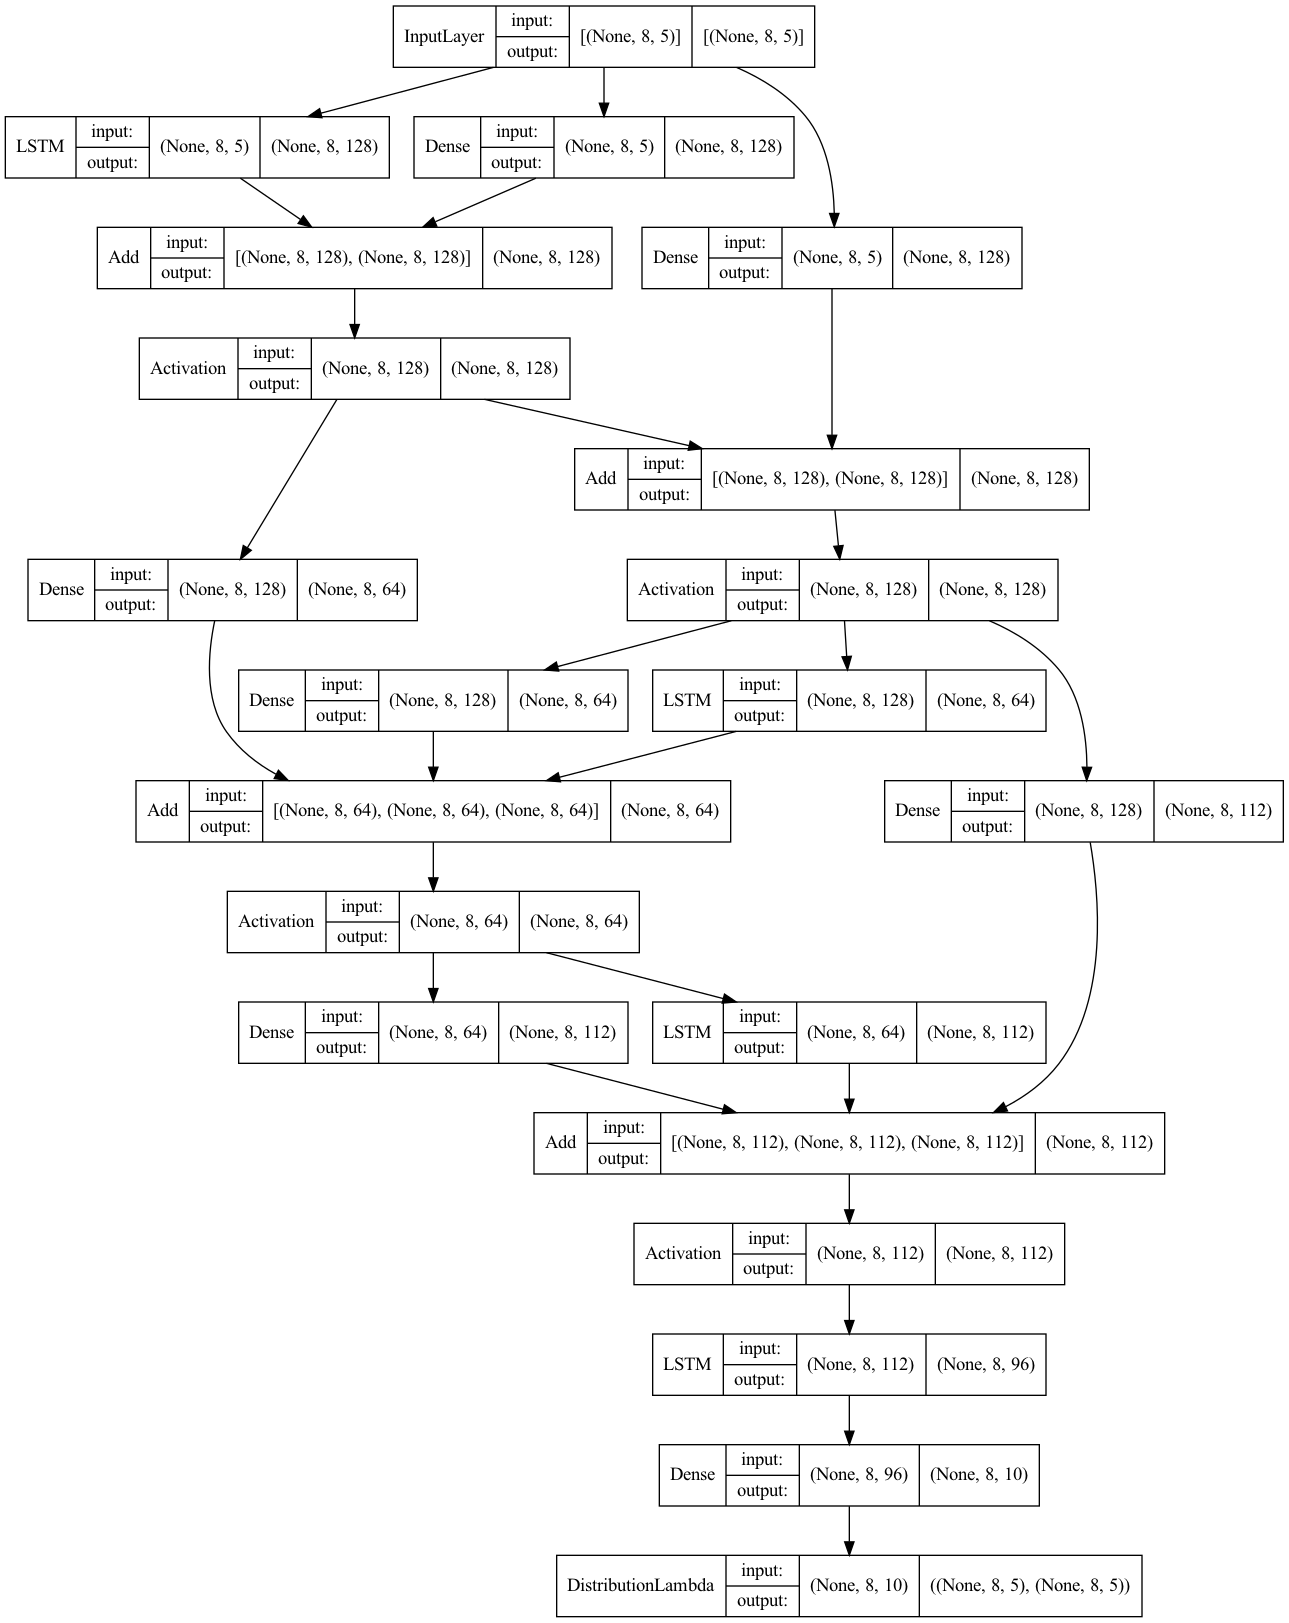

In [22]:
import json


i_max = results.objective.argmax()
best_score = results.iloc[i_max].objective
best_job_id = results.iloc[i_max].job_id
best_arch_seq = json.loads(results.iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)

plot_model(best_model, show_shapes=True, show_layer_names=False)

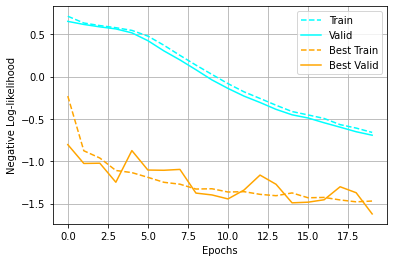

In [23]:
with open(f"agebo-results/save/history/{best_job_id}.json", "r") as f:
    best_history = json.load(f)

plt.figure()
plt.plot(history["loss"], color="cyan", linestyle="--", label="Train")
plt.plot(history["val_loss"], color="cyan", linestyle="-", label="Valid")
plt.plot(best_history["loss"], color="orange", linestyle="--", label="Best Train")
plt.plot(best_history["val_loss"], color="orange", linestyle="-", label="Best Valid")
plt.xlabel("Epochs")
plt.ylabel("Negative Log-likelihood")
plt.grid()
plt.legend()
plt.show()

In [24]:
best_model = tf.keras.models.load_model(f"agebo-results/save/model/{best_job_id}.h5", compile=False)

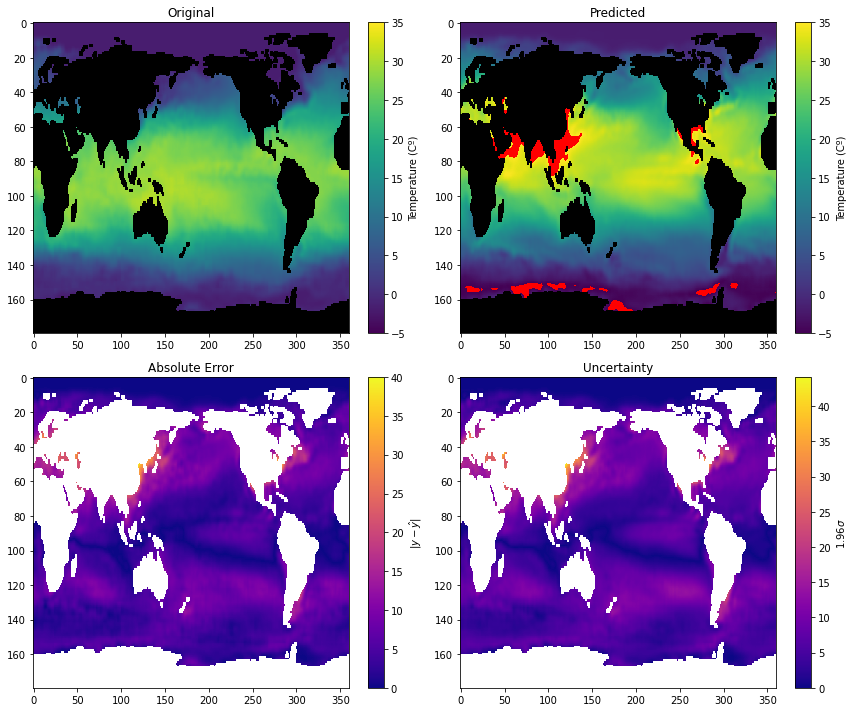

In [32]:
def plot_pred_from_best_model(idx):

    input_horizon = X_train.shape[1]
    idx_input = idx-input_horizon

    convert_func = lambda y_dist: (y_dist.loc.numpy(), y_dist.scale.numpy())
    mu, std = convert_func(model(X_train[idx_input:idx_input+1]))

    mu_ci = mu + 1.96*std
    mu_full = inverse_transform(mu)
    mu_ci_full = inverse_transform(mu_ci)
    uq = np.abs(mu_full - mu_ci_full)

    # idx = 9 # should be > than input_horizon!
    snapshot = train_data[idx].copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

    inv_y_pred = mu_ci_full[0][0].reshape(train_data.shape[1:])
    snapshot = inv_y_pred.copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

    input_horizon = X_train.shape[1]
    inv_uq = uq[0][0].reshape(train_data.shape[1:])
    snapshot = inv_uq.copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_uq = np.ma.masked_where(snapshot == 100, snapshot)

    plt.figure(figsize=(18, 10))
    ax = plt.subplot(2, 3, 1)
    ax.set_title("Original")
    im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5, vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 2)
    ax.set_title("Predicted")
    im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5, vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 4)
    ax.set_title("Absolute Error")
    err = np.abs(snapshot_masked_full - snapshot_masked_redu)
    im = plt.imshow(err, cmap="plasma", vmin=0, vmax=40, aspect="auto")
    plt.colorbar(im, label="$|y - \hat{y}|$")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 5)
    ax.set_title("Uncertainty")
    im = plt.imshow(snapshot_masked_uq, cmap="plasma", aspect="auto")
    plt.colorbar(im, label="$1.96 \sigma$")
    plt.tight_layout()

    plt.show()

plot_pred_from_best_model(idx=9)

In [26]:
print_scores(best_model)

Metric MSE
train: 0.0060
valid: 0.0063
test : 0.0081

Metric R2
train: 0.8592
valid: 0.8575
test : 0.7579



In [27]:
import ray

from deephyper.ensemble import UQBaggingEnsembleRegressor

if not(ray.is_initialized()):
    ray.init(num_cpus=1, num_gpus=1 if is_gpu_available else None)


ensemble = UQBaggingEnsembleRegressor(
    model_dir="agebo-results/save/model",
    loss=nll,  # default is nll
    size=5,
    verbose=True,
    ray_address="auto",
    num_cpus=1,
    num_gpus=1 if is_gpu_available else None,
    selection="caruana",
)

ensemble.fit(X_valid, y_valid)

print(f"Selected {len(ensemble.members_files)} members are: ", ensemble.members_files)

(model_predict pid=10757) Loading model 30.h5


(model_predict pid=10757) 2022-07-11 16:10:14.530832: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 14.h5
(model_predict pid=10757) Loading model 9.h5
(model_predict pid=10757) Loading model 10.h5
(model_predict pid=10757) Loading model 24.h5
(model_predict pid=10757) Loading model 8.h5
(model_predict pid=10757) Loading model 11.h5
(model_predict pid=10757) Loading model 25.h5
(model_predict pid=10757) Loading model 31.h5
(model_predict pid=10757) Loading model 21.h5
(model_predict pid=10757) Loading model 15.h5
(model_predict pid=10757) Loading model 7.h5
(model_predict pid=10757) Loading model 3.h5
(model_predict pid=10757) Loading model 2.h5
(model_predict pid=10757) Loading model 6.h5
(model_predict pid=10757) Loading model 1.h5
(model_predict pid=10757) Loading model 18.h5
(model_predict pid=10757) Loading model 5.h5
(model_predict pid=10757) Loading model 28.h5
(model_predict pid=10757) Loading model 4.h5
(model_predict pid=10757) Loading model 29.h5
(model_predict pid=10757) Loading model 19.

In [37]:
def ensemble_predict(X, kappa=1.96):
  y_pred_dist, var_aleatoric, var_epistemic = ensemble.predict_var_decomposition(X)

  mu = y_pred_dist.loc.numpy()
  std_aleatoric = np.sqrt(var_aleatoric)
  std_epistemic = np.sqrt(var_epistemic)

  mu_ci_aleatoric = mu + kappa*std_aleatoric
  mu_ci_epistemic = mu + kappa*std_epistemic
  mu_full = inverse_transform(mu)
  mu_ci_aleatoric = inverse_transform(mu_ci_aleatoric)
  mu_ci_epistemic = inverse_transform(mu_ci_epistemic)
  uq_aleatoric = np.abs(mu_full - mu_ci_aleatoric)
  uq_epistemic = np.abs(mu_full - mu_ci_epistemic)

  return mu_full, uq_aleatoric, uq_epistemic

(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
mu.shape=(1, 8, 64800)


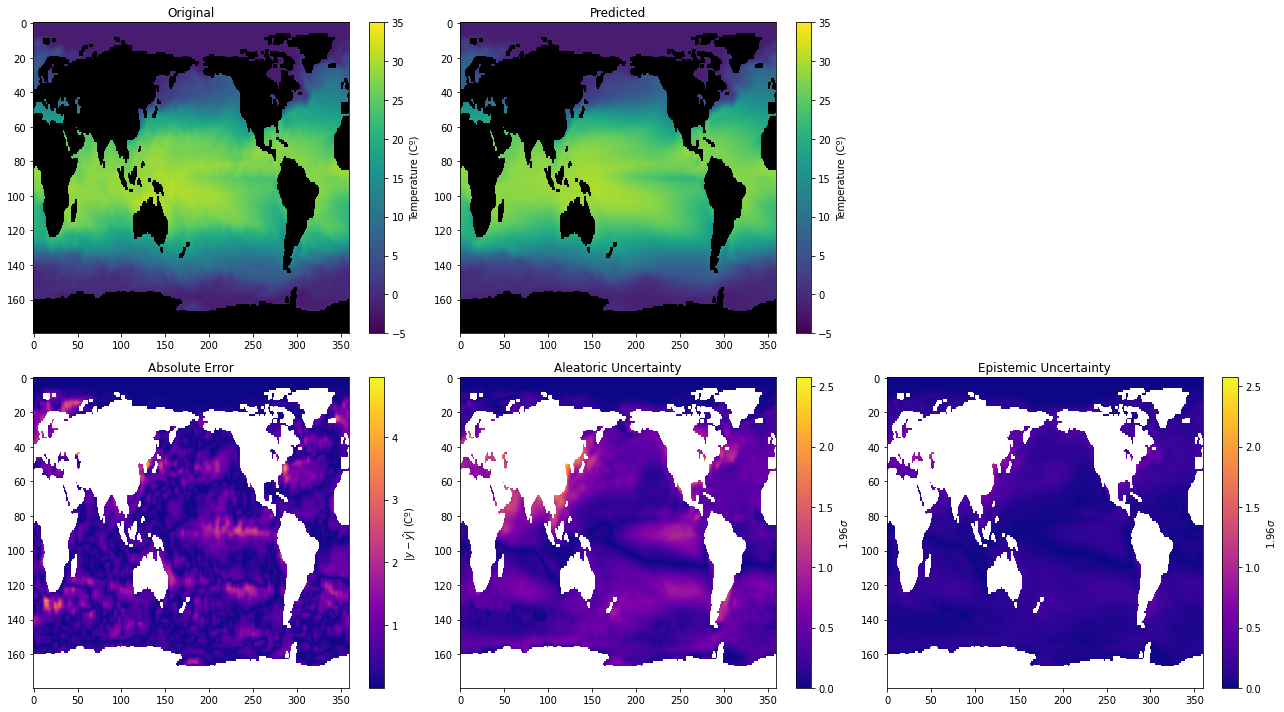

In [39]:
def plot_pred_from_ensemble(idx, kappa=1.96):

    input_horizon = X_train.shape[1]
    idx_input = idx-input_horizon
    mu, uq_aleatoric, uq_epistemic = ensemble_predict(X_train[idx_input:idx_input+1], kappa=kappa)

    snapshot = train_data[idx].copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_full = np.ma.masked_where(snapshot == 100, snapshot)

    inv_y_pred = mu[0][0].reshape(train_data.shape[1:])
    snapshot = inv_y_pred.copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_redu = np.ma.masked_where(snapshot == 100, snapshot)

    input_horizon = X_train.shape[1]
    snapshot = uq_aleatoric[0][0].reshape(train_data.shape[1:]).copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_uq_aleatoric = np.ma.masked_where(snapshot == 100, snapshot)

    input_horizon = X_train.shape[1]
    snapshot = uq_epistemic[0][0].reshape(train_data.shape[1:]).copy()
    snapshot[np.where(mask[0] == 0)] = 100
    snapshot_masked_uq_epistemic = np.ma.masked_where(snapshot == 100, snapshot)

    plt.figure(figsize=(18, 10))
    ax = plt.subplot(2, 3, 1)
    ax.set_title("Original")
    im = plt.imshow(snapshot_masked_full, cmap=palette, vmin=-5,vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 2)
    ax.set_title("Predicted")

    im = plt.imshow(snapshot_masked_redu, cmap=palette, vmin=-5,vmax=35, aspect="auto")
    plt.colorbar(im, label="Temperature (Cº)")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 4)
    ax.set_title("Absolute Error")
    err = np.abs(snapshot_masked_full - snapshot_masked_redu)
    im = plt.imshow(err, cmap="plasma", aspect="auto")
    plt.colorbar(im, label="$|y - \hat{y}|$ (Cº)")
    plt.tight_layout()

    vmax = max(snapshot_masked_uq_aleatoric.max(), snapshot_masked_uq_epistemic.max())

    ax = plt.subplot(2, 3, 5)
    ax.set_title("Aleatoric Uncertainty")
    im = plt.imshow(snapshot_masked_uq_aleatoric, cmap="plasma", vmin=0, vmax=vmax, aspect="auto")
    plt.colorbar(im, label=f"${kappa} \sigma$")
    plt.tight_layout()

    ax = plt.subplot(2, 3, 6)
    ax.set_title("Epistemic Uncertainty")
    im = plt.imshow(snapshot_masked_uq_epistemic, cmap="plasma", vmin=0, vmax=vmax, aspect="auto")
    plt.colorbar(im, label=f"${kappa} \sigma$")
    plt.tight_layout()

    plt.show()

plot_pred_from_ensemble(idx=9)

In [30]:
def print_scores_ensemble():
    scores = {"MSE": mse, "R2": r2}
    

    for metric_name, metric_func in scores.items():
        print(f"Metric {metric_name}")

        y_pred, _, _ = ensemble_predict(X_train)
        score_train = np.mean(metric_func(y_train, y_pred).numpy())

        y_pred, _, _ = ensemble_predict(X_valid)
        score_valid = np.mean(metric_func(y_valid, y_pred).numpy())

        y_pred, _, _ = ensemble_predict(X_test)
        score_test = np.mean(metric_func(y_test, y_pred).numpy())

        print(f"train: {score_train:.4f}")
        print(f"valid: {score_valid:.4f}")
        print(f"test : {score_test:.4f}")
        print()

print_scores_ensemble()

Metric MSE
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
train: 0.0021
valid: 0.0023
test : 0.0042

Metric R2
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
(model_predict pid=10757) Loading model 20.h5
(model_predict pid=10757) Loading model 24.h5
train: 0.9517
valid: 0.9475
test : 0.8884

